# Data Processing

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

### Data Importing :
The raw data is in a folder called rawdata.

And the cleaned data is in another folder called cleaned data, which is cleaned by our "TwitterDataCleaning.py".


In [2]:
NorthAmerica = pd.read_csv("predata/NorthAmerica_Trends_cleaned1230.csv",sep = ",", header = 0)
TwitterData = NorthAmerica
len(TwitterData)
TwitterData.head()

,hashtags,location,tweet
0,kidquestionsforhillary,NaN,do favorit color
1,gli51,NaN,michigan tech win 32 ot brent baltus hero husk...
2,messageformycrush,NaN,love preeto
3,NaN,NaN,stop
4,messageformycrush,NaN,ive pick wed dress tux alreadi book date venu ...


## Target Hastags :

we will build a data frame for the target hashtags.

It could be counted directly or set up by the top trends data from the twitter api.

### Counting.

In [3]:
ListHashtags = TwitterData.hashtags.values
listwords = []
for tag in ListHashtags:
    if type(tag) == str:
        listwords +=tag.split(" ")

In [4]:
#d = {x:lista.count(x) for x in lista}
from collections import Counter
tags_count=Counter(listwords)

In [5]:
import heapq
N = 10 # N is the number of most used hashtags.
index_tag = heapq.nlargest(N, tags_count.values())
print index_tag
tags_dataframe = pd.DataFrame({'hashtag':tags_count.keys(),'number': np.array(tags_count.values())   })
tags_dataframe.head()

[5494, 5249, 4665, 3248, 3125, 3058, 2558, 1389, 1314, 1310]


,hashtag,number
0,,1030
1,goodfood,1
2,foul,2
3,four,1
4,socialistdemocrats,1


In [6]:
TargetHashtags = tags_dataframe.iloc[np.where(tags_dataframe.number.values >=index_tag[-1])]
TargetHashtags
ListTargetHashtags = list(TargetHashtags['hashtag'])

## Top trends importing.

Here we import the top trends obtained from the api of twitter.

One for hashtags, and the other for keywords.

In [7]:
HashtagsTop = pd.read_csv('predata/Hashtags_cleaned1230.csv', header = 0)
KeywordsTop = pd.read_csv('predata/Keywords_cleaned1230.csv', header = 0)

In [8]:
#tags_dataframe.loc[tags_dataframe['hashtag'].isin(HashtagsTop['hashtag'])]

## Build up the train set.

We extract the tweet associated with the hashtags we want to study.

Fistly, we extract the tweets by the ListTargetHashtags

In [9]:
#ListTargetHashtags = ListTargetHashtags.remove("aldubrendezvous")
ListTargetHashtags = [ListTargetHashtags[i] for i in [0,2,4,5,6,7,8,9]]
print ListTargetHashtags

['videomtv2015', 'stormfrank', 'oldwestpickuplines', 'messageformycrush', 'lcfc', 'tamirrice', 'nyeonspringst', 'kidquestionsforhillary']


In [10]:
def tweets_extract(twitterdata,hashtag_list):
    targetdata = twitterdata.loc[twitterdata['hashtags'].isin(hashtag_list)]
    return targetdata

In [11]:
TargetData = tweets_extract(TwitterData,ListTargetHashtags)
TargetData = TargetData.drop('location',1)
TargetData = TargetData.loc[TargetData['tweet'].notnull()]
TargetData.head()

,hashtags,tweet
0,kidquestionsforhillary,do favorit color
2,messageformycrush,love preeto
4,messageformycrush,ive pick wed dress tux alreadi book date venu ...
11,messageformycrush,dis
12,kidquestionsforhillary,how mani time forgiven


In [12]:
len(TargetData)

14677

## Bag of words

In [13]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
Token=r'(^https?:\/\/.*[\r\n]*)|(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)|(\n)|([^\w])|(RT)'
vectorizer_c = CountVectorizer(analyzer = "word",   \
                             lowercase=True,
                             tokenizer = None,    \
#                              token_pattern = Token,  \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000) 
vectorizer_t = TfidfVectorizer(analyzer = "word",   \
                             lowercase=True, 
                             tokenizer = None,    \
#                              token_pattern = Token, \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000)

In [14]:
data_features = vectorizer_c.fit_transform(TargetData.tweet.values).toarray()


In [15]:
print data_features.shape
lable = TargetData.hashtags.values

(14677, 5000)


### Features Selection

In [16]:
from sklearn.feature_selection import SelectKBest,f_classif,chi2
num_feature = 500
Selec = SelectKBest(f_classif, k = num_feature )
train_data_features = Selec.fit_transform(data_features, lable)
#shape(train_data_features)

In [17]:
from random import sample
factor_sep = 1.0/3
sample_test = sample(xrange(len(lable)), int(len(lable)*factor_sep))
train_set= [i for i in range(len(lable)) if i not in sample_test]
test_set=[i for i in sample_test]

### Gaussian NB

In [18]:
from sklearn.naive_bayes import GaussianNB 

gnb = GaussianNB()
# gnb.fit([train_data_features[i] for i in range(len(lable)) if i not in sample_test], [lable[i] for i in range(len(lable)) if i not in sample_test])
# print gnb.score([train_data_features[i] for i in sample_test], [lable[i] for i in sample_test])
# feat_pred_gnb = gnb.predict([train_data_features[i] for i in sample_test])
gnb.fit(train_data_features[train_set] , lable[train_set])
print gnb.score(train_data_features[test_set] , lable[test_set])
feat_pred_gnb = gnb.predict(train_data_features[test_set])

0.648814390842


array([[ 312,    1,    7,    0,    3,    3,    6,   49],
       [  10,   88,    5,    0,    0,    4,    0,    7],
       [ 479,    6,  618,    0,   21,   19,   17,  299],
       [   0,    0,    0, 1070,    0,    0,    0,    0],
       [ 229,    6,   96,    0,  283,    9,    6,   96],
       [  49,    3,   25,    0,    8,  316,    7,   67],
       [ 115,    2,    9,    0,    7,   16,  303,   27],
       [   0,    0,    3,    0,    0,    2,    0,  184]])

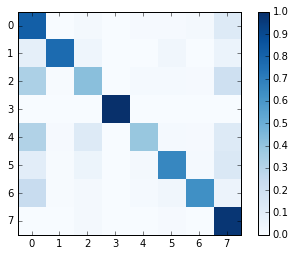

In [19]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(lable[test_set],feat_pred_gnb)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
plt.colorbar()
cm

In [20]:
from sklearn import metrics
print metrics.classification_report(lable[test_set], feat_pred_gnb)

             precision    recall  f1-score   support

kidquestionsforhillary       0.26      0.82      0.40       381
       lcfc       0.83      0.77      0.80       114
messageformycrush       0.81      0.42      0.56      1459
nyeonspringst       1.00      1.00      1.00      1070
oldwestpickuplines       0.88      0.39      0.54       725
 stormfrank       0.86      0.67      0.75       475
  tamirrice       0.89      0.63      0.74       479
videomtv2015       0.25      0.97      0.40       189

avg / total       0.81      0.65      0.67      4892



### KNN

We set the n_neighbors = 4.

In [21]:
from sklearn import neighbors
nn = neighbors.KNeighborsClassifier(n_neighbors = 4, weights="uniform")
nn.fit(train_data_features[train_set] , lable[train_set])
print nn.score(train_data_features[test_set] , lable[test_set])
feat_pred_nn = nn.predict(train_data_features[test_set])

0.720359771055


array([[ 166,    1,  130,    0,   80,    1,    3,    0],
       [   8,   51,   41,    0,   12,    1,    1,    0],
       [  27,    0, 1212,    0,  199,   11,    2,    8],
       [   0,    0,    0, 1070,    0,    0,    0,    0],
       [  23,    4,  297,    0,  397,    2,    2,    0],
       [  15,    3,  147,    0,   43,  265,    2,    0],
       [  30,    1,  174,    0,   73,   23,  178,    0],
       [   0,    0,    4,    0,    0,    0,    0,  185]])

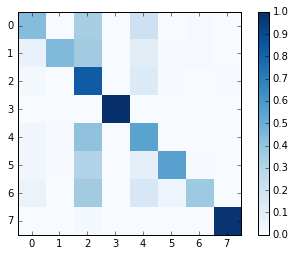

In [22]:
cm = confusion_matrix(lable[test_set],feat_pred_nn)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
plt.colorbar()
cm

In [23]:
print metrics.classification_report(lable[test_set], feat_pred_nn)

             precision    recall  f1-score   support

kidquestionsforhillary       0.62      0.44      0.51       381
       lcfc       0.85      0.45      0.59       114
messageformycrush       0.60      0.83      0.70      1459
nyeonspringst       1.00      1.00      1.00      1070
oldwestpickuplines       0.49      0.55      0.52       725
 stormfrank       0.87      0.56      0.68       475
  tamirrice       0.95      0.37      0.53       479
videomtv2015       0.96      0.98      0.97       189

avg / total       0.75      0.72      0.71      4892



### SVM

We select the kernel linear.

In [24]:
from sklearn import svm
svm = svm.SVC(kernel='linear')#‘linear!!!’ or 'poly'
factor_sep = 1.0/3
#sample_test = sample(xrange(len(lable)), int(len(lable)*factor_sep))
svm.fit(train_data_features[train_set] , lable[train_set])
print svm.score(train_data_features[test_set] , lable[test_set])
feat_pred_svm = svm.predict(train_data_features[test_set])

0.809076042518


array([[ 222,    0,   95,    0,   42,    5,   16,    1],
       [   1,   77,   26,    0,    5,    3,    2,    0],
       [  33,    0, 1318,    0,   85,   11,    5,    7],
       [   0,    0,    0, 1070,    0,    0,    0,    0],
       [  24,    6,  264,    0,  417,    7,    7,    0],
       [   8,    1,  120,    0,   23,  312,   10,    1],
       [  16,    1,   75,    0,   22,    8,  356,    1],
       [   0,    1,    0,    0,    0,    2,    0,  186]])

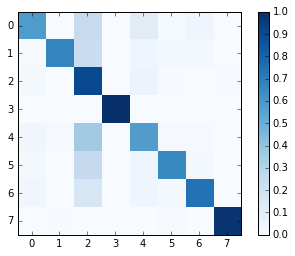

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(lable[test_set],feat_pred_svm)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
plt.colorbar()
cm

In [26]:
print metrics.classification_report(lable[test_set], feat_pred_svm)

             precision    recall  f1-score   support

kidquestionsforhillary       0.73      0.58      0.65       381
       lcfc       0.90      0.68      0.77       114
messageformycrush       0.69      0.90      0.79      1459
nyeonspringst       1.00      1.00      1.00      1070
oldwestpickuplines       0.70      0.58      0.63       725
 stormfrank       0.90      0.66      0.76       475
  tamirrice       0.90      0.74      0.81       479
videomtv2015       0.95      0.98      0.97       189

avg / total       0.82      0.81      0.81      4892



### Random Forest

We set the n_estimetors = 100.

In [27]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=500)
factor_sep = 1.0/3
#sample_test = sample(xrange(len(lable)), int(len(lable)*factor_sep))
RF.fit(train_data_features[train_set] , lable[train_set])
print RF.score(train_data_features[test_set] , lable[test_set])
feat_pred_rf = RF.predict(train_data_features[test_set])

0.811529026983


array([[ 232,    0,   91,    0,   29,    5,   23,    1],
       [   2,   69,   25,    0,   10,    5,    3,    0],
       [  28,    1, 1267,    0,  119,   22,   13,    9],
       [   0,    0,    0, 1070,    0,    0,    0,    0],
       [  28,    3,  226,    0,  445,   14,    9,    0],
       [   6,    0,  109,    0,   20,  328,   11,    1],
       [   8,    2,   69,    0,   19,    7,  374,    0],
       [   0,    0,    2,    0,    0,    2,    0,  185]])

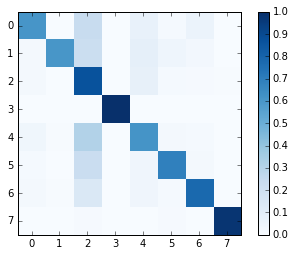

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(lable[test_set],feat_pred_rf)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
plt.colorbar()
cm

In [29]:
print metrics.classification_report(lable[test_set], feat_pred_rf)

             precision    recall  f1-score   support

kidquestionsforhillary       0.76      0.61      0.68       381
       lcfc       0.92      0.61      0.73       114
messageformycrush       0.71      0.87      0.78      1459
nyeonspringst       1.00      1.00      1.00      1070
oldwestpickuplines       0.69      0.61      0.65       725
 stormfrank       0.86      0.69      0.76       475
  tamirrice       0.86      0.78      0.82       479
videomtv2015       0.94      0.98      0.96       189

avg / total       0.82      0.81      0.81      4892



In [30]:
def PlotCM(lable,pred,title,ax):
    'Plot confusion matrix for supervised classification'
    cm = confusion_matrix(lable,pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ax.imshow(cm_normalized, interpolation='nearest',cmap = 'Blues')
    ax.set_title('Confusion Matrix for '+ title)
    #ax.colorbar()
    for y in range(len(ListTargetHashtags)):
        for x in range(len(ListTargetHashtags)):
            ax.text(x, y , '%.0f' % cm[y,x],
                     horizontalalignment='center',
                     verticalalignment='center',
                     )

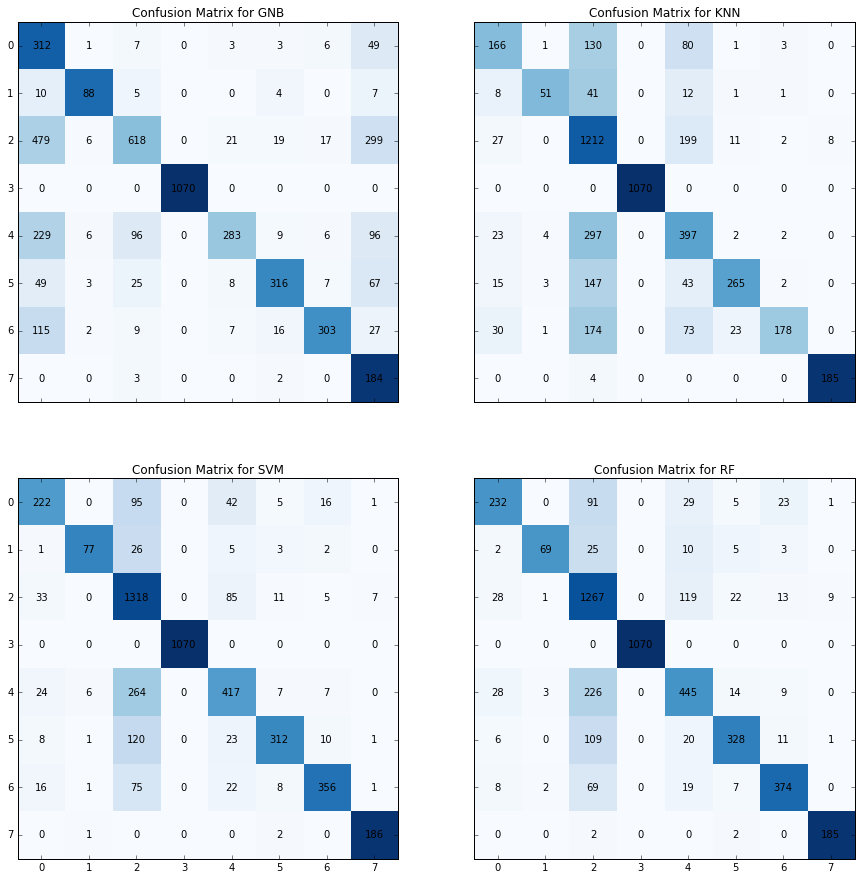

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
fig.set_size_inches(15, 15)
PlotCM(lable[test_set],feat_pred_gnb,"GNB",ax1)
PlotCM(lable[test_set],feat_pred_nn,"KNN",ax2)
PlotCM(lable[test_set],feat_pred_svm,"SVM",ax3)
PlotCM(lable[test_set],feat_pred_rf,"RF",ax4)

### Cross Validation for Gaussien NB

In [32]:
from sklearn import cross_validation
scores  = cross_validation.cross_val_score(gnb, train_data_features, lable, cv=10)
print(scores)
print(np.mean(scores))

[ 0.66258503  0.66462585  0.67006803  0.632403    0.63512594  0.6253406
  0.6691678   0.65893588  0.65665529  0.64685792]
0.652176533936


### Cross Validation for KNN

In [33]:
scores  = cross_validation.cross_val_score(nn, train_data_features, lable, cv=10)
print(scores)
print(np.mean(scores))

[ 0.68027211  0.73673469  0.69319728  0.69026549  0.74132063  0.73024523
  0.72237381  0.71896317  0.71672355  0.71448087]
0.71445768214


### Cross Validation for SVM

In [34]:
scores  = cross_validation.cross_val_score(svm, train_data_features, lable, cv=10)
print(scores)
print(np.mean(scores))

[ 0.79591837  0.82176871  0.81632653  0.80735194  0.81688223  0.80585831
  0.81718963  0.80695771  0.81023891  0.80122951]
0.809972184472


### Cross Validation for RF

In [35]:
scores  = cross_validation.cross_val_score(RF, train_data_features, lable, cv=10)
print(scores)
print(np.mean(scores))

KeyboardInterrupt: 

In [48]:
k_gnb = []
k_nn = []
k_svm = []
k_rf = []

for num_feature in range(100,2000,100):
    Selec = SelectKBest(f_classif, k = num_feature )
    train_data_features = Selec.fit_transform(data_features, lable)
    
    #GNB
    gnb.fit(train_data_features[train_set], lable[train_set])
    k_gnb.append(gnb.score(train_data_features[test_set], lable[test_set]))
    
    #KNN
    nn.fit(train_data_features[train_set], lable[train_set])
    k_nn.append(nn.score(train_data_features[test_set], lable[test_set]))
    
    #SVM  
    svm.fit(train_data_features[train_set], lable[train_set])
    k_svm.append(svm.score(train_data_features[test_set], lable[test_set]))
    
    #RF
    RF.fit(train_data_features[train_set], lable[train_set])
    k_rf.append(RF.score(train_data_features[test_set], lable[test_set]))


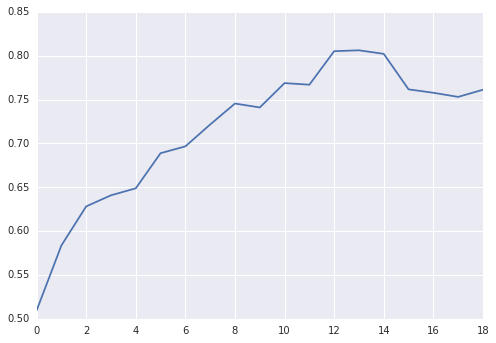

In [50]:
import seaborn as sns
sns.set_style("darkgrid")
sns.plt.plot(k_gnb)

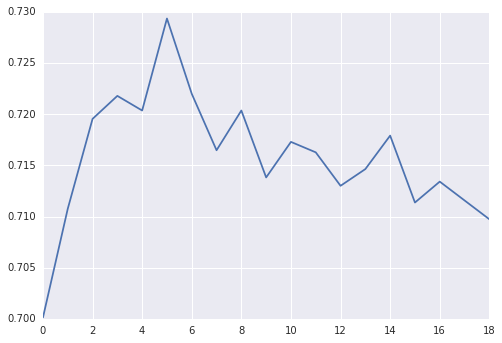

In [51]:
sns.plt.plot(k_nn)

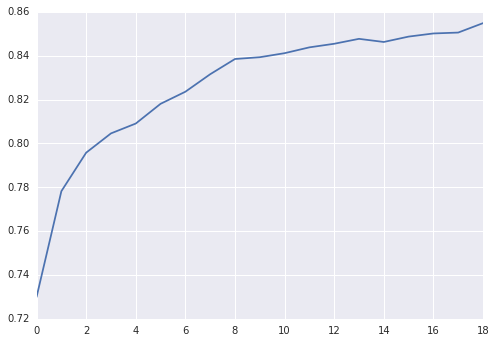

In [52]:
sns.plt.plot(k_svm)

In [55]:
BenchMark = pd.DataFrame({"GNB":k_gnb,'KNN':k_nn,"SVM":k_svm,'RF':k_rf})
BenchMark.index = ["k = "+ str(i) for i in range(100,2000,100)]
BenchMark

,GNB,KNN,RF,SVM
k = 100,0.509403,0.700123,0.735895,0.729967
k = 200,0.583606,0.710752,0.778823,0.778209
k = 300,0.628168,0.719542,0.795789,0.795789
k = 400,0.640842,0.721791,0.801922,0.804579
k = 500,0.648814,0.720360,0.812347,0.809076
k = 600,0.688880,0.729354,0.815822,0.818070
k = 700,0.696648,0.721995,0.816435,0.823590
k = 800,0.721586,0.716476,0.820728,0.831562
k = 900,0.745503,0.720360,0.827269,0.838512
k = 1000,0.741006,0.713818,0.828087,0.839330


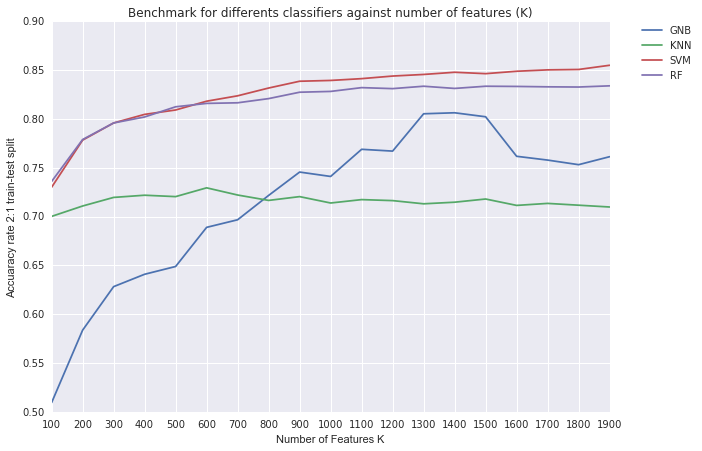

In [60]:
sns.plt.figure(figsize = (10,7))
sns.plt.plot(BenchMark["GNB"].values)
sns.plt.plot(BenchMark["KNN"].values)
sns.plt.plot(BenchMark["SVM"].values)
sns.plt.plot(BenchMark["RF"].values)
sns.plt.xticks(range(0,19),range(100,2000,100))
#sns.plt.legend(['GNB','KNN','SVM','RF'])
plt.legend(['GNB','KNN','SVM','RF'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.plt.xlabel("Number of Features K")
sns.plt.ylabel("Accuaracy rate 2:1 train-test split")
sns.plt.title("Benchmark for differents classifiers against number of features (K)")